In [116]:
import glob
import os
from collections import Counter

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers.recurrent import LSTM
from keras.models import Sequential, model_from_json
from keras.optimizers import Adam
from keras.utils import np_utils
from mutagen.easyid3 import EasyID3

In [31]:
def makeArtistList():
    path = "/home/Takumi/data/"
    l = ['Beethoven', 'Haydn', 'Bach']
    artist_list = []
    for i, name in enumerate(l):
        print('{} process start.'.format(name))
        p = path + name + '/cut/'
        file_count = len(os.listdir(p))
        l2 = [i] * file_count
        artist_list.extend(l2)

    counter = Counter(artist_list)
    print(counter)
    
    return artist_list

In [32]:
artist_list = makeArtistList()

Beethoven process start.
Haydn process start.
Bach process start.
Counter({2: 7277, 0: 2597, 1: 705})


In [4]:
def readwave(file):
    wav, samplerate = librosa.load(file)
    return wav, samplerate


def MelFilterBank(y, sr):
    return librosa.feature.melspectrogram(y=y, sr=sr)

In [5]:
path = "/home/Takumi/data/"
name_list = ['Beethoven', 'Haydn', 'Bach']
data_list = []
for name in name_list:
    print('{} process start.'.format(name))
    p = path + name + '/cut/'
    wav_list = sorted(list(glob.glob(p + "*.wav")))
    data_list.extend(wav_list)
print(len(data_list))

Beethoven process start.
Haydn process start.
Bach process start.
10579


In [6]:
data_x = np.empty([128, 1292])
for i in range(len(data_list)):
    wav, sr = readwave(data_list[i])
#     print(wav.shape)
#     print(sr)
    t = np.arange(0, len(wav)) / sr
    m = MelFilterBank(wav, sr)
#     print(m)
#     print(m.shape)
#     if not i:
#         data_x = np.stack([data_x, m], 0)
#     else:
#         data_x = np.r_[data_x, m]
    data_x = np.r_['0, 3, -1', data_x, m]
    
    if not i % 100:
        print(data_x.shape)

(2, 128, 1292)
(102, 128, 1292)
(202, 128, 1292)
(302, 128, 1292)
(402, 128, 1292)
(502, 128, 1292)
(602, 128, 1292)
(702, 128, 1292)
(802, 128, 1292)
(902, 128, 1292)
(1002, 128, 1292)
(1102, 128, 1292)
(1202, 128, 1292)
(1302, 128, 1292)
(1402, 128, 1292)
(1502, 128, 1292)
(1602, 128, 1292)
(1702, 128, 1292)
(1802, 128, 1292)
(1902, 128, 1292)
(2002, 128, 1292)
(2102, 128, 1292)
(2202, 128, 1292)
(2302, 128, 1292)
(2402, 128, 1292)
(2502, 128, 1292)
(2602, 128, 1292)
(2702, 128, 1292)
(2802, 128, 1292)
(2902, 128, 1292)
(3002, 128, 1292)
(3102, 128, 1292)
(3202, 128, 1292)
(3302, 128, 1292)
(3402, 128, 1292)
(3502, 128, 1292)
(3602, 128, 1292)
(3702, 128, 1292)
(3802, 128, 1292)
(3902, 128, 1292)
(4002, 128, 1292)
(4102, 128, 1292)
(4202, 128, 1292)
(4302, 128, 1292)
(4402, 128, 1292)
(4502, 128, 1292)
(4602, 128, 1292)
(4702, 128, 1292)
(4802, 128, 1292)
(4902, 128, 1292)
(5002, 128, 1292)
(5102, 128, 1292)
(5202, 128, 1292)
(5302, 128, 1292)
(5402, 128, 1292)
(5502, 128, 1292)
(560

In [51]:
data_x = np.delete(data_x, 0, 0)
print(data_x.shape)

(10577, 128, 1292)


In [117]:
def makeLSTMmodel(hidden=128, input_shape=(128, 1292,)):
    model = Sequential()
    model.add(LSTM(units=hidden, dropout=0.2, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units=hidden, dropout=0.2, input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-3), metrics=['accuracy'])
    return model

In [44]:
data_y = np.array(artist_list)

In [49]:
# data_y = np.delete(data_y, 0)
data_y = np_utils.to_categorical(data_y, 3)
print(data_y.shape)

(10577, 3)


In [120]:
model = makeLSTMmodel()
model.summary()
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="auto")
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.0001, verbose=1)
# history = model.fit(data_x, data_y, batch_size=64, epochs=100, validation_split=0.2, callbacks=[early_stopping, reduce_lr])
history = model.fit(data_x, data_y, batch_size=64, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 128, 128)          727552    
_________________________________________________________________
lstm_46 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_36 (Dense)             (None, 3)                 387       
Total params: 859,523
Trainable params: 859,523
Non-trainable params: 0
_________________________________________________________________
Train on 8461 samples, validate on 2116 samples
Epoch 1/100
8461/8461 [==============================] - 67s 8ms/step - loss: 0.7793 - accuracy: 0.6849 - val_loss: 0.1855 - val_accuracy: 0.9598
Epoch 2/100
8461/8461 [==============================] - 67s 8ms/step - loss: 0.4716 - accuracy: 0.8180 - val_loss: 0.3033 - val_accuracy: 0.8771
Epoch 3/100
8461/8461 [==============

In [123]:
with open('model.json', 'w') as json_file:
    json_file.write(model.to_json())
model.save_weights('main1.h5')

In [125]:
model_r = model_from_json(open('model.json', 'r').read())
model_r.load_weights('main1.h5')
model_r.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-3), metrics=['accuracy'])
history_r = model_r.fit(data_x, data_y, batch_size=64, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Train on 8461 samples, validate on 2116 samples
Epoch 1/100
8461/8461 [==============================] - 81s 10ms/step - loss: 0.1250 - accuracy: 0.9597 - val_loss: 0.5089 - val_accuracy: 0.8261
Epoch 2/100
8461/8461 [==============================] - 69s 8ms/step - loss: 0.1054 - accuracy: 0.9677 - val_loss: 0.3383 - val_accuracy: 0.8648
Epoch 3/100
8461/8461 [==============================] - 65s 8ms/step - loss: 0.1351 - accuracy: 0.9560 - val_loss: 0.4243 - val_accuracy: 0.8370
Epoch 4/100
8461/8461 [==============================] - 72s 8ms/step - loss: 0.0911 - accuracy: 0.9729 - val_loss: 0.4515 - val_accuracy: 0.8658
Epoch 5/100
8461/8461 [==============================] - 67s 8ms/step - loss: 0.0823 - accuracy: 0.9759 - val_loss: 0.2779 - val_accuracy: 0.9277
Epoch 6/100
8461/8461 [==============================] - 65s 8ms/step - loss: 0.0851 - accuracy: 0.9731 - val_loss: 0.4729 - val_accuracy: 0.8696
Epoch 7/100
8461/8461 [==============================] - 70s 8ms/step - los

In [119]:
del model
del early_stopping
# del reduce_lr
del history

In [122]:
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_"):
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                     Adam|      1184|
|                  Counter|      1056|
|                    Dense|      2000|
|                  Dropout|      1464|
|            EarlyStopping|      1464|
|                  EasyID3|      1056|
|                  Flatten|      1464|
|                       In|      1072|
|                    Input|       136|
|                     LSTM|      2000|
|            MelFilterBank|       136|
|                      Out|       368|
|        ReduceLROnPlateau|      1464|
|               Sequential|       888|
|              artist_list|     84728|
|              concatenate|       136|
|                data_list|     95320|
|                   data_x|13993455744|
|                   data_y|       112|
|           early_stopping|        56|
|                     exit|        56|
|              get_ipython|        64|
|                     glob|        80|
|                  histo

In [107]:
del m
del t
del wav

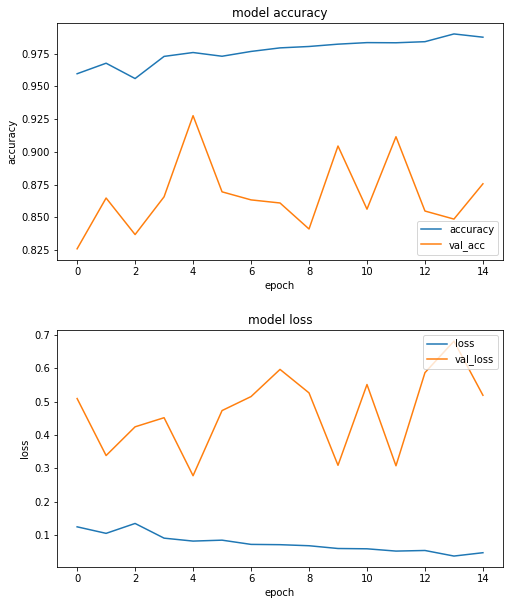

<Figure size 432x288 with 0 Axes>

In [128]:
%matplotlib inline

def plot_history(history):
    plt.figure(figsize=(8, 10))
    plt.subplots_adjust(hspace=0.3)
    
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], '-', label='accuracy')
    plt.plot(history.history['val_accuracy'], '-', label='val_acc')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')
    
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], '-', label='loss')
    plt.plot(history.history['val_loss'], '-', label='val_loss')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    plt.savefig('graph.png')
    plt.show()
    
plot_history(history_r)

In [129]:
with open('model.json', 'w') as json_file:
    json_file.write(model_r.to_json())
model_r.save_weights('main1.h5')